In [64]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [3]:
# Download historical data for NASDAQ
nasdaq_data = yf.download('^IXIC', start='2010-01-01', end='2023-05-01')

# Download historical data for NSE
nse_data = yf.download('^NSEI', start='2010-01-01', end='2023-05-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
print(nse_data)

                    Open          High           Low         Close   
Date                                                                 
2010-01-04   5200.899902   5238.450195   5167.100098   5232.200195  \
2010-01-05   5277.149902   5288.350098   5242.399902   5277.899902   
2010-01-06   5278.149902   5310.850098   5260.049805   5281.799805   
2010-01-07   5281.799805   5302.549805   5244.750000   5263.100098   
2010-01-08   5264.250000   5276.750000   5234.700195   5244.750000   
...                  ...           ...           ...           ...   
2023-04-24  17707.550781  17754.500000  17612.500000  17743.400391   
2023-04-25  17761.550781  17807.449219  17716.849609  17769.250000   
2023-04-26  17767.300781  17827.750000  17711.199219  17813.599609   
2023-04-27  17813.099609  17931.599609  17797.900391  17915.050781   
2023-04-28  17950.400391  18089.150391  17885.300781  18065.000000   

               Adj Close  Volume  
Date                              
2010-01-04   5232.2

In [5]:
# Extract the 'Close' prices from the data
nasdaq_close = nasdaq_data['Close']
nse_close = nse_data['Close']

# Combine the closing prices into a single DataFrame
combined_data = pd.concat([nasdaq_close, nse_close], axis=1)
combined_data.columns = ['NASDAQ', 'NSE']

# Calculate the correlation coefficient
correlation_coefficient = combined_data['NASDAQ'].corr(combined_data['NSE'])
print("Correlation Coefficient:", correlation_coefficient)

Correlation Coefficient: 0.9513138758576783


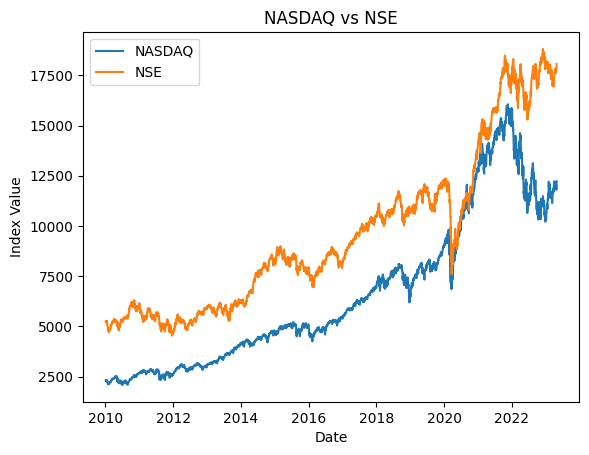

In [8]:
# Plotting both indices
plt.plot(nasdaq_close, label='NASDAQ')
plt.plot(nse_close, label='NSE')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.title('NASDAQ vs NSE')

# Add a legend
plt.legend()

# Display the plot
plt.show()


The actual lead value is varying across the years , however here we can see that NASDAQ is slightly ahead of NSE by observing the indices for a short interval. So the index to be used for parameter optimization is NASDAQ. By choosing an index which is leading NSE, we can predict the behaviour of NSE by looking at the recent past of the other index.

In [65]:
def calculate_keltner_channel(data, window=20, multiplier=2):
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3
    atr = calculate_average_true_range(data, window)
    upper_band = typical_price + multiplier * atr
    lower_band = typical_price - multiplier * atr
    return upper_band, lower_band

def calculate_bollinger_bands(data, window=20, num_std=2):
    rolling_mean = data['Close'].rolling(window).mean()
    rolling_std = data['Close'].rolling(window).std()
    upper_band = rolling_mean + num_std * rolling_std
    lower_band = rolling_mean - num_std * rolling_std
    return upper_band, lower_band

def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    exp_short = data['Close'].ewm(span=short_period, adjust=False).mean()
    exp_long = data['Close'].ewm(span=long_period, adjust=False).mean()
    macd_line = exp_short - exp_long
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    histogram = macd_line - signal_line
    return macd_line, signal_line, histogram

def calculate_average_true_range(data, window=14):
    high = data['High']
    low = data['Low']
    close_prev = data['Close'].shift(1)
    tr = np.maximum(high - low, np.abs(high - close_prev))
    atr = tr.rolling(window).mean()
    return atr

# Define a function to calculate performance metrics
def calculate_metrics(data):
    returns = data['Close'].pct_change()
    cumulative_return = (1 + returns).cumprod()[-1] - 1
    max_drawdown = (1 - (1 + returns).cumprod().rolling(window=len(data), min_periods=1).max()).min()
    annualized_return = (1 + cumulative_return) ** (252 / len(data)) - 1
    annualized_std = returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_std
    return max_drawdown, sharpe_ratio, cumulative_return

In [69]:
import itertools

# Define the parameter ranges to search
keltner_channel_params = {
    'window': range(10, 31, 5),
    'multiplier': np.arange(1.0, 3.0, 0.5)
}

bollinger_bands_params = {
    'window': range(10, 31, 5),
    'num_std': np.arange(1.0, 3.0, 0.5)
}

macd_params = {
    'short_period': range(6, 13),
    'long_period': range(20, 31),
    'signal_period': range(6, 13)
}

# Perform grid search for Keltner Channel
best_keltner_channel_params = None
best_keltner_channel_metrics = None

for params in itertools.product(*keltner_channel_params.values()):
    upper_band, lower_band = calculate_keltner_channel(nasdaq_data, *params)
    nasdaq_data['Keltner Channel Upper'] = upper_band
    nasdaq_data['Keltner Channel Lower'] = lower_band

    metrics = calculate_metrics(nasdaq_data)
    if best_keltner_channel_metrics is None or metrics > best_keltner_channel_metrics:
        best_keltner_channel_params = params
        best_keltner_channel_metrics = metrics

# Perform grid search for Bollinger Bands
best_bollinger_bands_params = None
best_bollinger_bands_metrics = None

for params in itertools.product(*bollinger_bands_params.values()):
    upper_band, lower_band = calculate_bollinger_bands(nasdaq_data, *params)
    nasdaq_data['Bollinger Bands Upper'] = upper_band
    nasdaq_data['Bollinger Bands Lower'] = lower_band

    metrics = calculate_metrics(nasdaq_data)
    if best_bollinger_bands_metrics is None or metrics > best_bollinger_bands_metrics:
        best_bollinger_bands_params = params
        best_bollinger_bands_metrics = metrics

# Perform grid search for MACD
best_macd_params = None
best_macd_metrics = None

for params in itertools.product(*macd_params.values()):
    macd_line, signal_line, histogram = calculate_macd(nasdaq_data, *params)
    nasdaq_data['MACD Line'] = macd_line
    nasdaq_data['Signal Line'] = signal_line

    metrics = calculate_metrics(nasdaq_data)
    if best_macd_metrics is None or metrics > best_macd_metrics:
        best_macd_params = params
        best_macd_metrics = metrics

# Print the optimized parameters and their corresponding metrics
print("Keltner Channel - Optimized Parameters:", best_keltner_channel_params)
print("Keltner Channel - Metrics (Max Drawdown, Sharpe Ratio, Cumulative Return):", best_keltner_channel_metrics)
print("Bollinger Bands - Optimized Parameters:", best_bollinger_bands_params)
print("Bollinger Bands - Metrics (Max Drawdown, Sharpe Ratio, Cumulative Return):", best_bollinger_bands_metrics)
print("MACD - Optimized Parameters:", best_macd_params)
print("MACD - Metrics (Max Drawdown, Sharpe Ratio, Cumulative Return):", best_macd_metrics)


Keltner Channel - Optimized Parameters: (10, 1.0)
Keltner Channel - Metrics (Max Drawdown, Sharpe Ratio, Cumulative Return): (-5.9560309532612905, 0.6477718685778071, 4.296514712190698)
Bollinger Bands - Optimized Parameters: (10, 1.0)
Bollinger Bands - Metrics (Max Drawdown, Sharpe Ratio, Cumulative Return): (-5.9560309532612905, 0.6477718685778071, 4.296514712190698)
MACD - Optimized Parameters: (6, 20, 6)
MACD - Metrics (Max Drawdown, Sharpe Ratio, Cumulative Return): (-5.9560309532612905, 0.6477718685778071, 4.296514712190698)


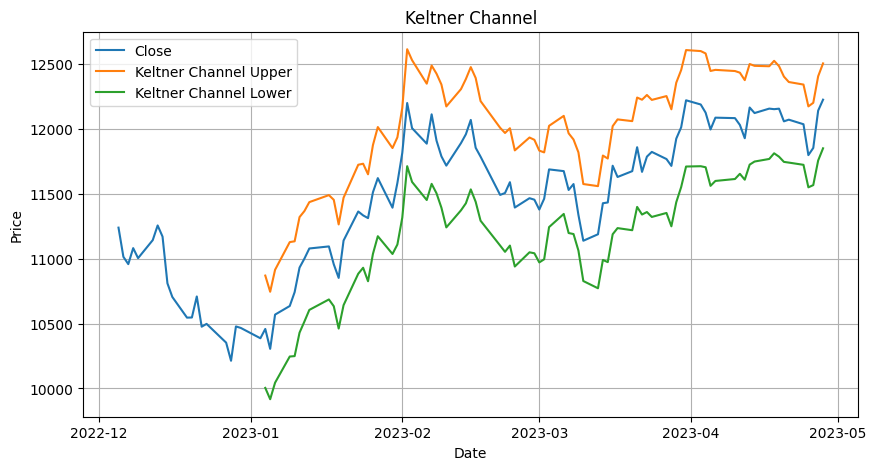

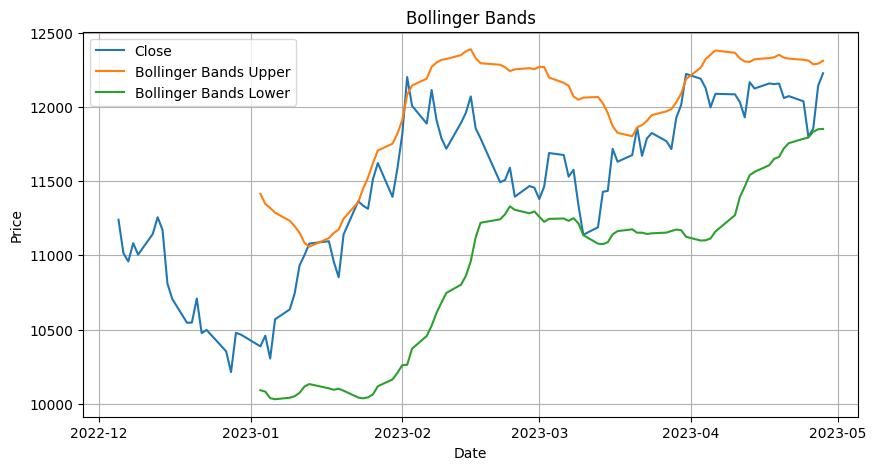

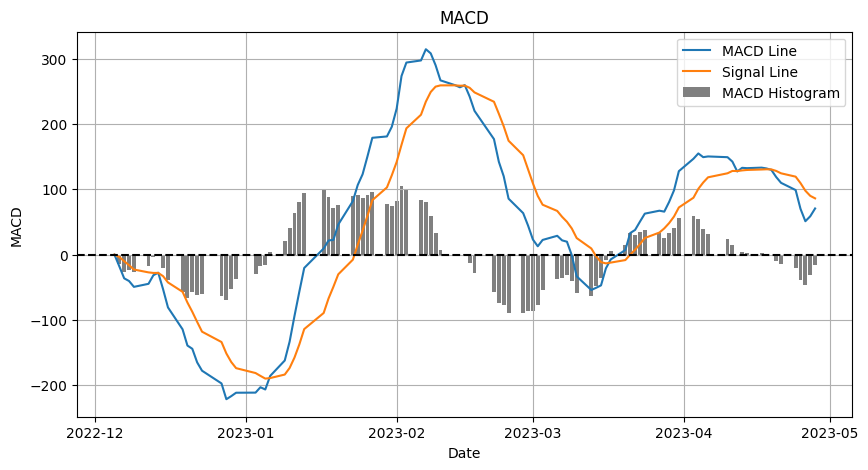

In [72]:
import matplotlib.pyplot as plt

# Select the last 100 days of NASDAQ data
last_100_days = nasdaq_data.tail(100)

# Calculate the indicators for the selected period
keltner_upper, keltner_lower = calculate_keltner_channel(last_100_days)
bollinger_upper, bollinger_lower = calculate_bollinger_bands(last_100_days)
macd_line, signal_line, histogram = calculate_macd(last_100_days)

# Plot Keltner Channel
plt.figure(figsize=(10, 5))
plt.plot(last_100_days['Close'], label='Close')
plt.plot(keltner_upper, label='Keltner Channel Upper')
plt.plot(keltner_lower, label='Keltner Channel Lower')
plt.title('Keltner Channel')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot Bollinger Bands
plt.figure(figsize=(10, 5))
plt.plot(last_100_days['Close'], label='Close')
plt.plot(bollinger_upper, label='Bollinger Bands Upper')
plt.plot(bollinger_lower, label='Bollinger Bands Lower')
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot MACD
plt.figure(figsize=(10, 5))
plt.plot(macd_line, label='MACD Line')
plt.plot(signal_line, label='Signal Line')
plt.bar(histogram.index, histogram, label='MACD Histogram', color='gray')
plt.axhline(0, color='black', linestyle='--')
plt.title('MACD')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend()
plt.grid(True)
plt.show()
